Class distribution:
 loan_status
0    2656
1    1613
Name: count, dtype: int64
XGBoost Accuracy: 0.9850
XGBoost ROC AUC:  0.9990

Confusion Matrix:
[[657   7]
 [  9 395]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       664
           1       0.98      0.98      0.98       404

    accuracy                           0.99      1068
   macro avg       0.98      0.98      0.98      1068
weighted avg       0.99      0.99      0.99      1068



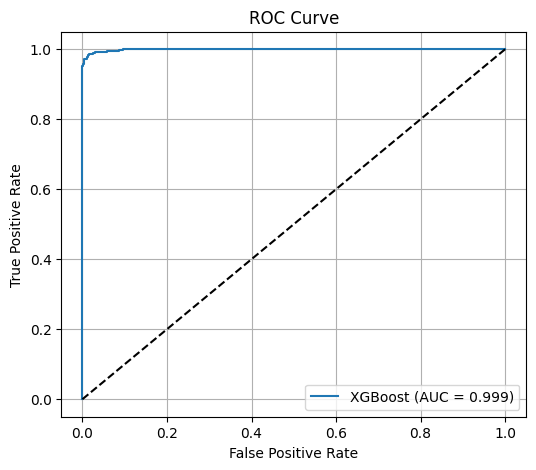


Feature importances:
cibil_score                 0.670241
loan_term                   0.179049
loan_amount                 0.024703
income_annum                0.024507
commercial_assets_value     0.016152
residential_assets_value    0.015490
bank_asset_value            0.014551
luxury_assets_value         0.013908
no_of_dependents            0.013853
loan_id                     0.011611
self_employed               0.008903
education                   0.007034
dtype: float32


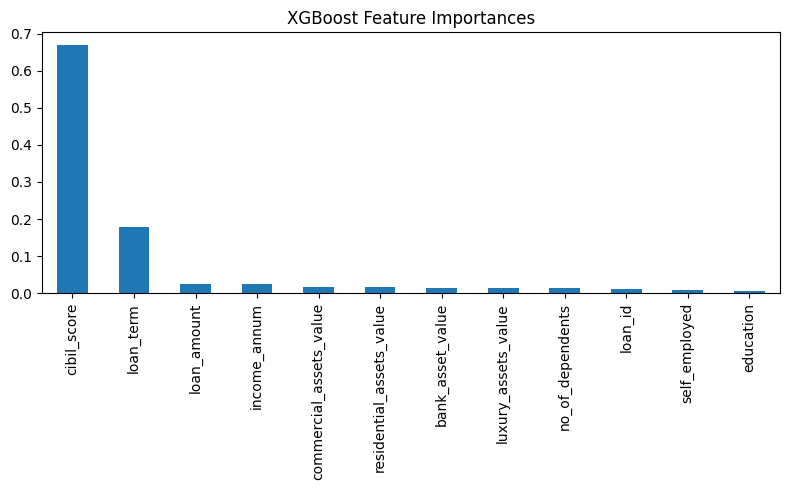


Saved model to xgb_loan_model.joblib


In [2]:
# XGBoost classifier pipeline
# Requirements: pip install xgboost scikit-learn pandas matplotlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# 1) Load cleaned dataset
df = pd.read_csv("cleaned_loan_data.csv")   # replace path if needed

# 2) Split features & target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Optional: If your classes are imbalanced, check counts
print("Class distribution:\n", y.value_counts())

# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4) Base XGBoost model (fast)
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Fit
xgb.fit(X_train, y_train)

# 5) Predict & Evaluate
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"XGBoost Accuracy: {acc:.4f}")
print(f"XGBoost ROC AUC:  {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6) ROC Curve (optional plot)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 7) Feature Importance
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print("\nFeature importances:")
print(feat_imp)

# Plot feature importances
plt.figure(figsize=(8,5))
feat_imp.plot(kind="bar")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# 8) Save the model
joblib.dump(xgb, "xgb_loan_model.joblib")
print("\nSaved model to xgb_loan_model.joblib")


# ------------------------------
# Optional: Hyperparameter tuning (RandomizedSearchCV)
# ------------------------------
# Note: This can be slow depending on data size. Use n_iter small (10-30) for quick search.
do_hyperopt = False   # set True to run tuning

if do_hyperopt:
    param_dist = {
        "n_estimators": [100, 200, 400, 600],
        "max_depth": [3, 4, 5, 6, 8],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.5, 0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2, 0.5],
        "min_child_weight": [1, 3, 5, 7]
    }

    rand_search = RandomizedSearchCV(
        estimator=XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1),
        param_distributions=param_dist,
        n_iter=25,
        scoring="roc_auc",
        cv=4,
        verbose=1,
        random_state=42
    )

    rand_search.fit(X_train, y_train)
    print("Best params:", rand_search.best_params_)
    best = rand_search.best_estimator_

    # Evaluate best estimator
    y_pred_best = best.predict(X_test)
    y_proba_best = best.predict_proba(X_test)[:, 1]
    print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_best))
    print("Tuned XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_best))

    # Save tuned model
    joblib.dump(best, "xgb_loan_model_tuned.joblib")
    print("Saved tuned model to xgb_loan_model_tuned.joblib")
